# Obtained_data:

In [1]:
import numpy as np 

In [2]:
import pandas as pd
user_data=pd.read_csv("Final_User_Dataset.csv")
item_data=pd.read_csv("Final_Anime_Dataset.csv")
user_input=pd.read_csv("User_input.csv")



C:\Users\Lenovo\AppData\Local\Temp\ipykernel_17696\192256860.py:3: DtypeWarning: Columns (20) have mixed types. Specify dtype option on import or set low_memory=False.
  item_data=pd.read_csv("Final_Anime_Dataset.csv")


In [3]:
user_data[user_data.columns[21]].dtype

dtype('float64')

In [4]:
user_data.iloc[21, :].unique()

array([347, 'troublesome4u', 'Male', 8.64, 167.0, 8.84, 8.83, 7.93, 9.56,
       7.06, 8.1, 8.67, 8.0, 6.8, 8.47, 7.17, 7.53, 6.47, 8.54, 6.83,
       8.57, 8.32, 7.87, 9.0, 8.69, 10.0, 47, 'Gen_X', 0, 1], dtype=object)

In [5]:
# user_data["avg_Romance"] = pd.to_numeric(user_data["avg_Romance"], errors="coerce")


In [6]:
from sklearn.base import BaseEstimator, TransformerMixin
import pandas as pd

class GenreRatingTypeConverter(BaseEstimator, TransformerMixin):
    """
    A transformer that converts all columns with a specific prefix to numeric data types,
    handling non-numeric values by converting them to NaN.
    
    Parameters:
    -----------
    column_prefix : str, default='avg_'
        Prefix used to identify columns for conversion
    errors : str, default='coerce'
        How to handle errors in conversion:
        - 'ignore': leave invalid values as is
        - 'raise': raise an exception
        - 'coerce': convert invalid values to NaN
    downcast : str or None, default=None
        Type to downcast to if possible ('integer', 'signed', 'unsigned', 'float')
    """
    
    def __init__(self, column_prefix='avg_', errors='coerce', downcast=None):
        self.column_prefix = column_prefix
        self.errors = errors
        self.downcast = downcast
        self.columns_converted_ = None
    
    def fit(self, X, y=None):
        """
        Identify columns to convert based on prefix.
        
        Parameters:
        -----------
        X : pandas.DataFrame
            Input DataFrame
        y : array-like, default=None
            Not used, present for API consistency
            
        Returns:
        --------
        self
        """
        # Identify columns starting with the specified prefix
        self.columns_converted_ = [col for col in X.columns if col.startswith(self.column_prefix)]
        return self
    
    def transform(self, X):
        """
        Convert identified columns to numeric types.
        
        Parameters:
        -----------
        X : pandas.DataFrame
            Input DataFrame to transform
            
        Returns:
        --------
        pandas.DataFrame
            Transformed DataFrame with numeric columns
        """
        X_result = X.copy()
        
        for column in self.columns_converted_:
            X_result[column] = pd.to_numeric(X_result[column], 
                                             errors=self.errors, 
                                             downcast=self.downcast)
        
        return X_result
    
    def get_feature_names_out(self, input_features=None):
        """
        Get output feature names.
        
        Parameters:
        -----------
        input_features : array-like of str or None, default=None
            Input features
            
        Returns:
        --------
        list
            List of converted column names
        """
        return self.columns_converted_

In [7]:
# Initialize the transformer
genre_converter = GenreRatingTypeConverter(column_prefix='avg_', errors='coerce')

# Apply the transformation
user_data = genre_converter.fit_transform(user_data)

# Check the data types of converted columns
for col in genre_converter.columns_converted_:
    print(f"{col}: {user_data[col].dtype}")

avg_Action: float64
avg_Adventure: float64
avg_Avant Garde: float64
avg_Award Winning: float64
avg_Boys Love: float64
avg_Comedy: float64
avg_Drama: float64
avg_Ecchi: float64
avg_Erotica: float64
avg_Fantasy: float64
avg_Girls Love: float64
avg_Gourmet: float64
avg_Hentai: float64
avg_Horror: float64
avg_Mystery: float64
avg_Romance: float64
avg_Sci-Fi: float64
avg_Slice of Life: float64
avg_Sports: float64
avg_Supernatural: float64
avg_Suspense: float64


In [8]:
user_data["avg_Romance"].dtype

dtype('float64')

In [9]:
min_value = user_data['avg_Mystery'].min()
max_value = user_data['avg_Mystery'].max()
print(f"Range of avg_Mystery: {min_value} to {max_value}")

Range of avg_Mystery: 1.0 to 10.0


In [10]:
user_data["avg_Mystery"].dtype

dtype('float64')

In [11]:
item_data.shape

(19848, 1571)

In [12]:
user_data.columns

Index(['user_id', 'Username', 'Gender', 'Mean Score', 'Completed',
       'avg_Action', 'avg_Adventure', 'avg_Avant Garde', 'avg_Award Winning',
       'avg_Boys Love', 'avg_Comedy', 'avg_Drama', 'avg_Ecchi', 'avg_Erotica',
       'avg_Fantasy', 'avg_Girls Love', 'avg_Gourmet', 'avg_Hentai',
       'avg_Horror', 'avg_Mystery', 'avg_Romance', 'avg_Sci-Fi',
       'avg_Slice of Life', 'avg_Sports', 'avg_Supernatural', 'avg_Suspense',
       'Age', 'Viewer_Category', 'Age_Group__Gen_Alpha', 'Age_Group__Zoomers',
       'Age_Group__Millennials', 'Age_Group__Gen_X', 'Age_Group__Boomers_Plus',
       'Category_Classic_Era_Fans', 'Category_Gen_Alpha_Viewers',
       'Category_Millennial_Favorites', 'Category_Retro_Anime_Lovers',
       'Category_Zoomer_Picks'],
      dtype='object')

In [13]:
item_data.columns
item_data.sample()

,anime_id,Name,English name,Other name,Score,Genres,Synopsis,Episodes,Aired,Premiered,...,"Studio_pH Studio, D & D Pictures","Studio_pH Studio, Noovo",Studio_production doA,Studio_studio MOTHER,Studio_studio YOG,Studio_trenova,Studio_ufotable,"Studio_ufotable, Shaft, A-1 Pictures, SILVER LINK., Lerche, Lay-duce, CloverWorks, Drive","Studio_ufotable, feel., Studio Flag",Release_Year
11804,36040,Knights of the Zodiac: Saint Seiya,UNKNOWN,聖闘士星矢: Knights of the Zodiac,5.13,"Action, Adventure, Fantasy, Sci-Fi","Zeus had a daughter named Athena, the goddess ...",12,"Jul 19, 2019 to Jan 23, 2020",UNKNOWN,...,0,0,0,0,0,0,0,0,0,2019.0


In [14]:
from sklearn.preprocessing import OneHotEncoder

# Initialize the OneHotEncoder
encoder = OneHotEncoder(sparse_output=False, drop=None, dtype=int)

# Fit and transform the 'Gender' column
gender_encoded = encoder.fit_transform(user_data[['Gender']])

# Get the column names for the encoded features
gender_columns = encoder.get_feature_names_out(['Gender'])

# Create a DataFrame for the encoded features
gender_encoded_df = pd.DataFrame(gender_encoded, columns=gender_columns)

# Concatenate the one-hot encoded columns with the original DataFrame
user_data = pd.concat([user_data, gender_encoded_df], axis=1)

# Drop the original 'Gender' column if no longer needed
user_data.drop(columns=['Gender'], inplace=True)

# Display the updated DataFrame
print(user_data.head())

   user_id  Username  Mean Score  Completed  avg_Action  avg_Adventure  \
0        1     Xinil        7.37      233.0        7.68           7.90   
1       20    vondur        8.06       94.0        8.02           8.24   
2       66    Hiromi        7.53      148.0        7.49           7.31   
3       82    Achtor        7.17      153.0        7.36           7.71   
4      112  luffykun        8.77      125.0        8.60           8.36   

   avg_Avant Garde  avg_Award Winning  avg_Boys Love  avg_Comedy  ...  \
0             8.00               8.18           7.06        7.02  ...   
1             9.00               8.43           7.06        7.77  ...   
2             7.00               7.90           7.06        7.46  ...   
3             8.80               8.25           7.06        7.05  ...   
4             7.93               9.80           7.06        8.67  ...   

   Age_Group__Gen_X  Age_Group__Boomers_Plus  Category_Classic_Era_Fans  \
0                 1                      

In [15]:
item_data["Rating"].values

array(['R - 17+ (violence & profanity)', 'R - 17+ (violence & profanity)',
       'PG-13 - Teens 13 or older', ..., 'PG-13 - Teens 13 or older',
       'PG-13 - Teens 13 or older', 'PG-13 - Teens 13 or older'],
      dtype=object)

In [16]:
user_data.shape

(71278, 40)

In [17]:
user_data.columns

Index(['user_id', 'Username', 'Mean Score', 'Completed', 'avg_Action',
       'avg_Adventure', 'avg_Avant Garde', 'avg_Award Winning',
       'avg_Boys Love', 'avg_Comedy', 'avg_Drama', 'avg_Ecchi', 'avg_Erotica',
       'avg_Fantasy', 'avg_Girls Love', 'avg_Gourmet', 'avg_Hentai',
       'avg_Horror', 'avg_Mystery', 'avg_Romance', 'avg_Sci-Fi',
       'avg_Slice of Life', 'avg_Sports', 'avg_Supernatural', 'avg_Suspense',
       'Age', 'Viewer_Category', 'Age_Group__Gen_Alpha', 'Age_Group__Zoomers',
       'Age_Group__Millennials', 'Age_Group__Gen_X', 'Age_Group__Boomers_Plus',
       'Category_Classic_Era_Fans', 'Category_Gen_Alpha_Viewers',
       'Category_Millennial_Favorites', 'Category_Retro_Anime_Lovers',
       'Category_Zoomer_Picks', 'Gender_Female', 'Gender_Male',
       'Gender_Non-Binary'],
      dtype='object')

In [18]:
item_data.columns


Index(['anime_id', 'Name', 'English name', 'Other name', 'Score', 'Genres',
       'Synopsis', 'Episodes', 'Aired', 'Premiered',
       ...
       'Studio_pH Studio, D & D Pictures', 'Studio_pH Studio, Noovo',
       'Studio_production doA', 'Studio_studio MOTHER', 'Studio_studio YOG',
       'Studio_trenova', 'Studio_ufotable',
       'Studio_ufotable, Shaft, A-1 Pictures, SILVER LINK., Lerche, Lay-duce, CloverWorks, Drive',
       'Studio_ufotable, feel., Studio Flag', 'Release_Year'],
      dtype='object', length=1571)

In [19]:

item_data.isna().sum()

anime_id                                                                                       0
Name                                                                                           0
English name                                                                                   0
Other name                                                                                     0
Score                                                                                       5183
                                                                                            ... 
Studio_trenova                                                                                 0
Studio_ufotable                                                                                0
Studio_ufotable, Shaft, A-1 Pictures, SILVER LINK., Lerche, Lay-duce, CloverWorks, Drive       0
Studio_ufotable, feel., Studio Flag                                                            0
Release_Year                  

In [20]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline

class ColumnDropper(BaseEstimator, TransformerMixin):
    """
    A transformer that drops specified columns from a DataFrame.
    
    Parameters:
    -----------
    columns_to_drop : list of str
        List of column names to drop by default.
    """
    def __init__(self, columns_to_drop=None):
        self.columns_to_drop = columns_to_drop if columns_to_drop else []

    def fit(self, X, y=None):
        # No fitting required for this transformer
        return self

    def transform(self, X):
        """
        Drops the specified columns from the DataFrame.
        
        Parameters:
        -----------
        X : pandas.DataFrame
            Input DataFrame
            
        Returns:
        --------
        pandas.DataFrame
            Transformed DataFrame with specified columns dropped
        """
        X_transformed = X.drop(columns=self.columns_to_drop, errors='ignore')
        return X_transformed

# Define the default columns to drop
default_columns_to_drop = [
    "Genres", "Episodes", "Rating_UNKNOWN", "Producers", "Aired",
    "Premiered", "Status", "Studios", "Licensors", "Duration"
]

# Create the pipeline
pipeline = Pipeline([
    ('column_dropper', ColumnDropper(columns_to_drop=default_columns_to_drop))
])

# Apply the pipeline to the item_data DataFrame
filtered_item_data_df = pipeline.fit_transform(item_data)

# Display the resulting DataFrame
print(filtered_item_data_df.head())

   anime_id                             Name             English name  \
0         1                     Cowboy Bebop             Cowboy Bebop   
1         5  Cowboy Bebop: Tengoku no Tobira  Cowboy Bebop: The Movie   
2         6                           Trigun                   Trigun   
3         7               Witch Hunter Robin       Witch Hunter Robin   
4         8                   Bouken Ou Beet   Beet the Vandel Buster   

                         Other name  Score  \
0                         カウボーイビバップ   8.75   
1                    カウボーイビバップ 天国の扉   8.38   
2                             トライガン   8.22   
3  Witch Hunter ROBIN (ウイッチハンターロビン)   7.25   
4                            冒険王ビィト   6.94   

                                            Synopsis    Source  \
0  Crime is timeless. By the year 2071, humanity ...  Original   
1  Another day, another bounty—such is the life o...  Original   
2  Vash the Stampede is the man with a $$60,000,0...     Manga   
3  Robin Sena is a p

In [21]:
filtered_item_data_df.columns

Index(['anime_id', 'Name', 'English name', 'Other name', 'Score', 'Synopsis',
       'Source', 'Rating', 'Rank', 'Popularity',
       ...
       'Studio_pH Studio, D & D Pictures', 'Studio_pH Studio, Noovo',
       'Studio_production doA', 'Studio_studio MOTHER', 'Studio_studio YOG',
       'Studio_trenova', 'Studio_ufotable',
       'Studio_ufotable, Shaft, A-1 Pictures, SILVER LINK., Lerche, Lay-duce, CloverWorks, Drive',
       'Studio_ufotable, feel., Studio Flag', 'Release_Year'],
      dtype='object', length=1562)

In [22]:
filtered_item_data_df.shape
filtered_item_data_df.sample(5)

,anime_id,Name,English name,Other name,Score,Synopsis,Source,Rating,Rank,Popularity,...,"Studio_pH Studio, D & D Pictures","Studio_pH Studio, Noovo",Studio_production doA,Studio_studio MOTHER,Studio_studio YOG,Studio_trenova,Studio_ufotable,"Studio_ufotable, Shaft, A-1 Pictures, SILVER LINK., Lerche, Lay-duce, CloverWorks, Drive","Studio_ufotable, feel., Studio Flag",Release_Year
4847,7512,Dambo,UNKNOWN,dambo,4.99,"The haunting, hallucinatory, and oddly cute jo...",Original,PG-13 - Teens 13 or older,0,14151,...,0,0,0,0,0,0,0,0,0,2004.0
19360,54739,Make Love,UNKNOWN,メイクラブ,NaN,A short film by Genshou Yasuda.,Original,G - All Ages,17849,20711,...,0,0,0,0,0,0,0,0,0,2020.0
7567,19519,Dream Creator feat. GUMI,UNKNOWN,Dream Creator feat. GUMI,5.74,Music video for Dream Creator feat. GUMI by Ha...,Music,G - All Ages,0,11865,...,0,0,0,0,0,0,0,0,0,2013.0
6262,11787,Toriko: Barbarian Ivy wo Hokaku Seyo!,UNKNOWN,トリコ バーバリアンアイビーを捕獲せよ!,6.58,Special shown at the Jump Super Anime Tour in ...,Unknown,PG-13 - Teens 13 or older,5931,9196,...,0,0,0,0,0,0,0,0,0,2010.0
4966,7904,Kemono no Souja Erin Recaps,UNKNOWN,獣の奏者 エリン 総集編,6.78,Summarized version of the 50-episode TV series...,Novel,G - All Ages,4935,9874,...,0,0,0,0,0,0,0,0,0,2010.0


In [23]:
filtered_item_data_df["Score"].isna().sum()

5183

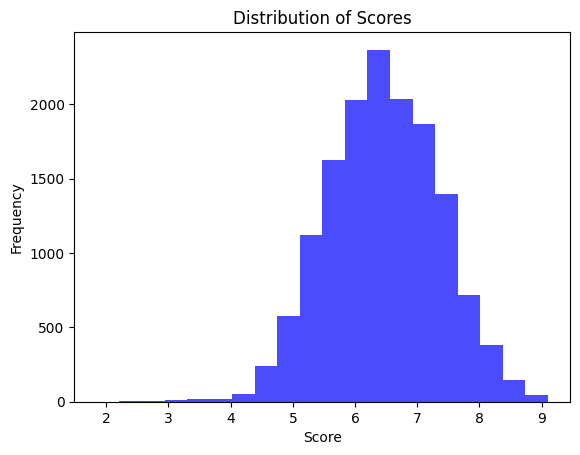

In [24]:
import matplotlib.pyplot as plt

plt.hist(filtered_item_data_df['Score'].dropna(), bins=20, color='blue', alpha=0.7)
plt.title('Distribution of Scores')
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.show()


In [25]:
from sklearn.preprocessing import FunctionTransformer
import pandas as pd

# Define the function for the transformation
def impute_score_column(filtered_item_data_df):
    """
    Replaces 'UNKNOWN' with NaN in the 'Score' column and imputes missing values using the mean.
    
    Parameters:
    -----------
    filtered_item_data_df : pandas.DataFrame
        The DataFrame containing the 'Score' column to be processed.
        
    Returns:
    --------
    pandas.DataFrame
        The DataFrame with the 'Score' column imputed.
    """
    # Replace 'UNKNOWN' with NaN
    filtered_item_data_df['Score'] = filtered_item_data_df['Score'].replace('UNKNOWN', pd.NA)
    
    # Impute missing values with the mean
    filtered_item_data_df['Score'] = filtered_item_data_df['Score'].astype(float).fillna(filtered_item_data_df['Score'].astype(float).mean())
    
    return filtered_item_data_df

# Create the FunctionTransformer
impute_score_transformer = FunctionTransformer(impute_score_column)

# Apply the transformer
filtered_item_data_df = impute_score_transformer.transform(filtered_item_data_df)

# Verify that there are no missing values left in 'Score'
print(filtered_item_data_df['Score'].isna().sum())  # Should print 0


0


In [26]:
from sklearn.preprocessing import FunctionTransformer
import pandas as pd

def filter_score_and_release_year(df):
    """
    Filters rows where both 'Score' and 'Release_Year' are not null.

    Parameters:
    -----------
    df : pandas.DataFrame
        The input DataFrame to filter.

    Returns:
    --------
    pandas.DataFrame
        The filtered DataFrame.
    """
    return df[df["Score"].notna() & df["Release_Year"].notna()]

# Create the FunctionTransformer
filter_transformer = FunctionTransformer(filter_score_and_release_year)

# Apply the transformer to the filtered_item_data_df
filtered_item_data_df = filter_transformer.transform(filtered_item_data_df)

# Verify the result
print(filtered_item_data_df.head())

   anime_id                             Name             English name  \
0         1                     Cowboy Bebop             Cowboy Bebop   
1         5  Cowboy Bebop: Tengoku no Tobira  Cowboy Bebop: The Movie   
2         6                           Trigun                   Trigun   
3         7               Witch Hunter Robin       Witch Hunter Robin   
4         8                   Bouken Ou Beet   Beet the Vandel Buster   

                         Other name  Score  \
0                         カウボーイビバップ   8.75   
1                    カウボーイビバップ 天国の扉   8.38   
2                             トライガン   8.22   
3  Witch Hunter ROBIN (ウイッチハンターロビン)   7.25   
4                            冒険王ビィト   6.94   

                                            Synopsis    Source  \
0  Crime is timeless. By the year 2071, humanity ...  Original   
1  Another day, another bounty—such is the life o...  Original   
2  Vash the Stampede is the man with a $$60,000,0...     Manga   
3  Robin Sena is a p

In [27]:
print(filtered_item_data_df.isna().sum())

anime_id                                                                                    0
Name                                                                                        0
English name                                                                                0
Other name                                                                                  0
Score                                                                                       0
                                                                                           ..
Studio_trenova                                                                              0
Studio_ufotable                                                                             0
Studio_ufotable, Shaft, A-1 Pictures, SILVER LINK., Lerche, Lay-duce, CloverWorks, Drive    0
Studio_ufotable, feel., Studio Flag                                                         0
Release_Year                                                

In [28]:
filtered_item_data_df.shape

(19848, 1562)

In [29]:
user_data.columns

Index(['user_id', 'Username', 'Mean Score', 'Completed', 'avg_Action',
       'avg_Adventure', 'avg_Avant Garde', 'avg_Award Winning',
       'avg_Boys Love', 'avg_Comedy', 'avg_Drama', 'avg_Ecchi', 'avg_Erotica',
       'avg_Fantasy', 'avg_Girls Love', 'avg_Gourmet', 'avg_Hentai',
       'avg_Horror', 'avg_Mystery', 'avg_Romance', 'avg_Sci-Fi',
       'avg_Slice of Life', 'avg_Sports', 'avg_Supernatural', 'avg_Suspense',
       'Age', 'Viewer_Category', 'Age_Group__Gen_Alpha', 'Age_Group__Zoomers',
       'Age_Group__Millennials', 'Age_Group__Gen_X', 'Age_Group__Boomers_Plus',
       'Category_Classic_Era_Fans', 'Category_Gen_Alpha_Viewers',
       'Category_Millennial_Favorites', 'Category_Retro_Anime_Lovers',
       'Category_Zoomer_Picks', 'Gender_Female', 'Gender_Male',
       'Gender_Non-Binary'],
      dtype='object')

In [30]:
filtered_item_data_df.columns

Index(['anime_id', 'Name', 'English name', 'Other name', 'Score', 'Synopsis',
       'Source', 'Rating', 'Rank', 'Popularity',
       ...
       'Studio_pH Studio, D & D Pictures', 'Studio_pH Studio, Noovo',
       'Studio_production doA', 'Studio_studio MOTHER', 'Studio_studio YOG',
       'Studio_trenova', 'Studio_ufotable',
       'Studio_ufotable, Shaft, A-1 Pictures, SILVER LINK., Lerche, Lay-duce, CloverWorks, Drive',
       'Studio_ufotable, feel., Studio Flag', 'Release_Year'],
      dtype='object', length=1562)

In [31]:
user_input.columns

Index(['Username', 'Gender', 'Mean Score', 'Completed', 'Birth_Year',
       'user_id', 'anime_id', 'Anime Title', 'rating', 'Genres',
       'Genre_Action', 'Genre_Adventure', 'Genre_Avant Garde',
       'Genre_Award Winning', 'Genre_Boys Love', 'Genre_Comedy', 'Genre_Drama',
       'Genre_Ecchi', 'Genre_Erotica', 'Genre_Fantasy', 'Genre_Girls Love',
       'Genre_Gourmet', 'Genre_Hentai', 'Genre_Horror', 'Genre_Mystery',
       'Genre_Romance', 'Genre_Sci-Fi', 'Genre_Slice of Life', 'Genre_Sports',
       'Genre_Supernatural', 'Genre_Suspense'],
      dtype='object')

In [32]:
# Check if any column in filtered_item_data_df contains the value 'UNKNOWN'
columns_with_unknown = filtered_item_data_df.columns[filtered_item_data_df.isin(['UNKNOWN']).any()]

# Print the columns that contain 'UNKNOWN'
print("Columns containing 'UNKNOWN':", list(columns_with_unknown))


Columns containing 'UNKNOWN': ['English name', 'Other name', 'Scored By']


In [33]:
unknown_counts = filtered_item_data_df.isin(['UNKNOWN']).sum().sum()
print(f"Total instances with 'UNKNOWN' values: {unknown_counts}")

Total instances with 'UNKNOWN' values: 15974


In [38]:
from scipy.sparse import csr_matrix, hstack
import numpy as np
import pandas as pd

def prepare_training_data(user_input_df, user_data_df, filtered_item_data_df):
    """
    Prepares training data for a neural network using sparse matrices during processing,
    then converts back to dense arrays in the output.
    
    Parameters:
    -----------
    user_input_df : DataFrame
        Contains user ratings for anime with columns including user_id, anime_id, rating
    user_data_df : DataFrame
        Contains user demographic data and average genre ratings
    filtered_item_data_df : DataFrame
        Contains anime metadata including genres, types, and ratings
        
    Returns:
    --------
    dict
        A dictionary containing:
        - 'X_U': User features array (dense)
        - 'X_A': Anime features array (dense)
        - 'Y': Rating values array
        - 'X_U_columns': List of column names for user features
        - 'X_A_columns': List of column names for anime features
        - 'Y_column': Name of the rating column
        - 'X_U_indices': List of indices for user features
        - 'X_A_indices': List of indices for anime features
        - 'Y_index': Index of the rating column
        - 'merged_df': The merged and cleaned dataframe
    """
    # Step 1: Merge dataframes with suffixes to handle column conflicts
    merged_df = user_input_df.merge(user_data_df, on='user_id', suffixes=('', '_user'))
    merged_df = merged_df.merge(filtered_item_data_df, on='anime_id', suffixes=('', '_anime'))
    
    # Step 2: Identify columns to drop (non-numerical or identifiers)
    columns_to_drop = ['Username', 'user_id', 'anime_id', 'Anime Title', 
                     'Name', 'English name', 'Other name', 'Synopsis', 
                     'Source', "Scored by", 'Image URL']
    
    # Only drop columns that actually exist in the merged dataframe
    columns_to_drop = [col for col in columns_to_drop if col in merged_df.columns]
    
    # Drop identified columns
    cleaned_df = merged_df.drop(columns_to_drop, axis=1)
    
    # Step 3: Define columns for each component
    X_U_columns = [
        'Mean Score', 'Completed',
        'avg_Action', 'avg_Adventure', 'avg_Avant Garde', 'avg_Award Winning',
        'avg_Boys Love', 'avg_Comedy', 'avg_Drama', 'avg_Ecchi', 'avg_Erotica',
        'avg_Fantasy', 'avg_Girls Love', 'avg_Gourmet', 'avg_Hentai',
        'avg_Horror', 'avg_Mystery', 'avg_Romance', 'avg_Sci-Fi',
        'avg_Slice of Life', 'avg_Sports', 'avg_Supernatural', 'avg_Suspense',
        'Gender_Female', 'Gender_Male', 'Gender_Non-Binary','Age',
        'Category_Classic_Era_Fans', 'Category_Gen_Alpha_Viewers',
        'Category_Millennial_Favorites', 
        'Category_Retro_Anime_Lovers', 
        'Category_Zoomer_Picks'
    ]
    
    excluded_columns = ['anime_id', 'Name', 'English name', 'Other name',
                      'Score', "Synopsis", "Source", "Rank","Rating"]
    
    X_A_columns = [col for col in filtered_item_data_df.columns 
                  if col not in excluded_columns and col in cleaned_df.columns]
    X_U_columns = [col for col in X_U_columns if col in cleaned_df.columns]
    
    Y_column = "rating"
    if Y_column not in cleaned_df.columns:
        raise ValueError(f"Rating column '{Y_column}' not found in merged dataframe")
    
    # Step 4: Get indices for features
    X_U_indices = [cleaned_df.columns.get_loc(col) for col in X_U_columns]
    X_A_indices = [cleaned_df.columns.get_loc(col) for col in X_A_columns]
    Y_index = cleaned_df.columns.get_loc(Y_column)
    
    # Step 5: Process with sparse matrices
    # Convert relevant portions to sparse format
    X_U_sparse = csr_matrix(cleaned_df.iloc[:, X_U_indices].values)
    X_A_sparse = csr_matrix(cleaned_df.iloc[:, X_A_indices].values)
    
    # Perform sparse operations if needed (e.g., scaling)
    # ... (your sparse-compatible preprocessing here) ...
    
    # Convert back to dense for output (if your model requires dense inputs)
    X_U = X_U_sparse.toarray()
    X_A = X_A_sparse.toarray()
    Y = cleaned_df.iloc[:, Y_index].values
    
    return {
        "X_U": X_U,
        "X_A": X_A,
        "Y": Y,
        "X_U_columns": X_U_columns,
        "X_A_columns": X_A_columns,
        "Y_column": Y_column,
        "X_U_indices": X_U_indices,
        "X_A_indices": X_A_indices,
        "Y_index": Y_index,
        "merged_df": cleaned_df,
    }


In [39]:
# Prepare the training data
# Select a smaller dataframe with 200000 samples from user_input
user_input_sample = user_input.sample(n=200000, random_state=42)

# Ensure all columns in user_input_sample, user_data, and filtered_item_data_df are numeric
user_input_sample = user_input_sample.select_dtypes(include=[np.number])
user_data = user_data.select_dtypes(include=[np.number])
filtered_item_data_df = filtered_item_data_df.select_dtypes(include=[np.number])

# Prepare the training data using the sampled dataframe
result = prepare_training_data(user_input_sample, user_data, filtered_item_data_df)

# Access the prepared data
X_U = result['X_U']  # User features
X_A = result['X_A']  # Anime features
Y = result['Y']      # Ratings

# You can also access indices if needed
X_U_indices = result['X_U_indices']
X_A_indices = result['X_A_indices']

In [40]:
len(result['X_U_columns']) # Number of user feature names

32

In [41]:
X_U.shape

(200000, 32)

In [42]:
X_A.shape

(200000, 1551)

In [43]:
Y.shape

(200000,)

In [44]:
Y[:10]

array([ 7,  9, 10,  9, 10,  7,  9,  2,  8,  8], dtype=int64)

# Neural Network for implementing Content Based Filtering:

In [45]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split


In [46]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
import numpy as np

# --- Scaling the data ---
# Create scalers
user_scaler = StandardScaler()
anime_scaler = StandardScaler()

# Ensure all columns in X_A are numeric
# Convert categorical columns (e.g., 'Rating') to numeric using one-hot encoding
#X_A_df = pd.DataFrame(X_A, columns=result['X_A_columns'])  # Convert X_A to DataFrame for easier processing

# print(X_A_df.columns)  # Check the columns after encoding
# Scale the features
X_U_scaled = user_scaler.fit_transform(X_U)
X_A_scaled = anime_scaler.fit_transform(X_A)

# --- Splitting the scaled data ---
# First split: 80% train+val, 20% test
X_U_temp, X_U_test, X_A_temp, X_A_test, Y_temp, Y_test = train_test_split(
    X_U_scaled, X_A_scaled, Y, test_size=0.2, random_state=42
)

# Second split: 75% train, 25% validation (results in 60% train, 20% val, 20% test overall)
X_U_train, X_U_val, X_A_train, X_A_val, Y_train, Y_val = train_test_split(
    X_U_temp, X_A_temp, Y_temp, test_size=0.25, random_state=42
)

print(f"Training set: {X_U_train.shape[0]} samples")
print(f"Validation set: {X_U_val.shape[0]} samples")
print(f"Test set: {X_U_test.shape[0]} samples")

print(X_U_train.shape)


Training set: 120000 samples
Validation set: 40000 samples
Test set: 40000 samples
(120000, 32)


In [47]:
# --- TensorFlow model ---
# Set random seed for reproducibility
tf.random.set_seed(42)

# Define inputs for user and item features
user_input = tf.keras.Input(shape=(X_U_train.shape[1],), name="user_input")
item_input = tf.keras.Input(shape=(X_A_train.shape[1],), name="item_input")

# Define user network with dropout for regularization
user_nn = tf.keras.Sequential([
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(32, activation='linear')
], name="user_nn")

# Define item network with dropout for regularization
item_nn = tf.keras.Sequential([
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(32, activation='linear')
], name="item_nn")

# Pass inputs through respective networks
vu = user_nn(user_input)
va = item_nn(item_input)

# Compute dot product
output = tf.keras.layers.Dot(axes=1)([vu, va])

# Create model
model = tf.keras.Model([user_input, item_input], output)

# Define callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    min_lr=0.00001
)

# Compile model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='mean_squared_error',
    metrics=['mean_absolute_error']
)

# Model summary
model.summary()

# Train the model
history = model.fit(
    [X_U_train, X_A_train],
    Y_train,
    validation_data=([X_U_val, X_A_val], Y_val),
    epochs=60,
    batch_size=32,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)



Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ user_input          │ (None, 32)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ item_input          │ (None, 1551)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ user_nn             │ (None, 32)        │     53,472 │ user_input[0][0]  │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ item_nn             │ (None, 32)        │    442,336 │ item_input[0][0]  │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dot (Dot)           │ (None, 1)         │          0 │ user_nn[0][0],    │
│                     │                   │            │ item_nn[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 495,808 (1.89 MB)

 Trainable params: 494,016 (1.88 MB)

 Non-trainable params: 1,792 (7.00 KB)

Epoch 1/60
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - loss: 26.4473 - mean_absolute_error: 3.3699 - val_loss: 2.0115 - val_mean_absolute_error: 1.0726 - learning_rate: 0.0010
Epoch 2/60
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - loss: 2.1409 - mean_absolute_error: 1.1249 - val_loss: 1.9435 - val_mean_absolute_error: 1.0639 - learning_rate: 0.0010
Epoch 3/60
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - loss: 2.0153 - mean_absolute_error: 1.0883 - val_loss: 1.8566 - val_mean_absolute_error: 1.0275 - learning_rate: 0.0010
Epoch 4/60
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - loss: 1.9256 - mean_absolute_error: 1.0627 - val_loss: 1.8558 - val_mean_absolute_error: 1.0210 - learning_rate: 0.0010
Epoch 5/60
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - loss: 1.8517 - mean_absolute_error: 1.0405 - val_loss: 1.8701 - val_mean_absolute_error: 1.0222 - learning_rate: 0.0010
Epoch 6/60
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - loss: 1.7902 - mean_absolute_error: 1.0235 - val_loss: 1.

In [48]:
# Evaluate on test set
test_results = model.evaluate([X_U_test, X_A_test], Y_test, verbose=1)
print(f"Test loss (MSE): {test_results[0]}")
print(f"Test MAE: {test_results[1]}")

1250/1250 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 1.8571 - mean_absolute_error: 1.0247
Test loss (MSE): 1.8746775388717651
Test MAE: 1.029756784439087


In [53]:
# Save in TensorFlow SavedModel format
model.export('../saved_model/recommender_model_6')

# Save in HDF5 format
model.save('../saved_model/recommender_model_6.h5', save_format='h5')


INFO:tensorflow:Assets written to: ../saved_model/recommender_model_6\assets


INFO:tensorflow:Assets written to: ../saved_model/recommender_model_6\assets


Saved artifact at '../saved_model/recommender_model_6'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): List[TensorSpec(shape=(None, 32), dtype=tf.float32, name='user_input'), TensorSpec(shape=(None, 1551), dtype=tf.float32, name='item_input')]
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  2157527331856: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2157527331472: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2157527330704: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2157527332432: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2157527330896: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2157527331088: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2157527331664: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2157527329552: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2157527331280: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2157527329744: Tenso

In [ ]:
# # Save in TensorFlow SavedModel format
# model.export('../saved_model/recommender_model_2')

# # Save in HDF5 format
# model.save('../recommender_model_2.h5', save_format='h5')


In [54]:
model=tf.keras.models.load_model('../saved_model/recommender_model_6.h5')


In [55]:
import numpy as np
X_U_test[:5]


array([[-0.25989455,  0.32317614,  0.24692126,  0.51687892, -0.1317057 ,
        -0.28708446,  1.57206042, -0.27704778,  0.16021278,  0.157398  ,
         0.07581517,  0.29228819,  0.25436898,  0.71397845,  0.11641071,
         0.16433943,  0.25063178, -0.08446916,  0.29093007,  0.14058532,
         0.09544477,  0.11204122,  0.44291244, -0.6441875 ,  0.65238654,
        -0.07278681, -0.27320431,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ],
       [-1.11070908, -0.39802264, -0.82766483, -1.06390135,  1.00888589,
        -0.63833223, -1.10495582, -0.98105748, -1.56264593, -0.81415629,
        -3.2394846 , -1.25647216, -3.49930131,  0.5472529 ,  0.08170883,
         0.0280102 , -1.25054341, -1.64605076, -0.42125418, -0.54687925,
        -0.60209419, -0.98151224, -1.66798113,  1.55234306, -1.53283358,
        -0.07278681, -0.00468354,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ],
       [ 0.60325062, -0.81813842,  0.22304156,  1.1284

In [56]:
X_A_test[:5]

array([[ 1.69920481, -0.38654972, -0.72123611, ..., -0.00223607,
        -0.01245086,  0.75442207],
       [ 1.5770615 , -0.38654972, -0.71797694, ..., -0.00223607,
        -0.01245086, -0.7860036 ],
       [-0.47928185, -0.04080992, -0.29046938, ..., -0.00223607,
        -0.01245086,  1.87473164],
       [-0.72674102, -0.25985486,  0.2798146 , ..., -0.00223607,
        -0.01245086,  0.05422858],
       [-0.7373162 , -0.24332945,  0.3301047 , ..., -0.00223607,
        -0.01245086,  0.61438337]])

In [57]:
#Make predictions on X-U_test and X-A_test
predictions = model.predict([X_U_test[:20], X_A_test[:20]])
predictions[:20]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step


array([[7.463675 ],
       [6.215206 ],
       [8.96331  ],
       [6.965341 ],
       [7.7632103],
       [7.7176785],
       [7.10887  ],
       [8.700842 ],
       [8.901836 ],
       [8.921344 ],
       [9.275683 ],
       [8.296733 ],
       [7.4497223],
       [7.7219424],
       [8.352077 ],
       [8.433327 ],
       [7.4812627],
       [8.009763 ],
       [7.835172 ],
       [8.43903  ]], dtype=float32)

In [58]:
Y_test[:20]

array([ 8,  5,  9,  4,  7,  8,  8,  9,  9, 10,  9,  7,  8,  8,  7,  9,  6,
        7,  7,  7], dtype=int64)

In [ ]:
# Optional: Plot training history
# Uncomment if you're running in an environment that supports plotting
"""
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['mean_absolute_error'], label='Training MAE')
plt.plot(history.history['val_mean_absolute_error'], label='Validation MAE')
plt.title('Mean Absolute Error Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.tight_layout()
plt.show()
"""